# WGAN-GP For 128x128

## Prerequisite

In [ ]:
!pip install tensorflow==1.14
!pip install tensorflow-gpu==1.14
!pip install keras==2.2.3

     |████████████████████████████████| 109.2MB 100kB/s 
     |████████████████████████████████| 3.2MB 56.8MB/s 
     |████████████████████████████████| 491kB 45.9MB/s 
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorflow 2.2.0
    Uninstalling tensorflow-2.2.0:
      Successfully uninstalled tensorflow-2.2.0
     |████████████████████████████████| 377.0MB 45kB/s 
     |████████████████████████████████| 317kB 4.4MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


## Necessary Imports 

In [ ]:
import numpy as np # linear algebra

import os
import sys
from tqdm import tqdm, tqdm_notebook
import glob
import shutil
import time      # time.perf_counter()
import random

import matplotlib.pyplot as plt
import cv2

import xml.etree.ElementTree as ET

from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.preprocessing.image import image

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

## Constants

In [ ]:
# image size
img_size = 128
channels = 3
img_shape = (img_size, img_size, channels)    # (64,64,3)

# z(latent variable) size
z_dim = 100
z_shape = (z_dim,)

# gradient penalty coefficient "λ"
penaltyLambda = 10    # d_loss = f_loss - r_loss + λ･penalty

# critic(discriminator) iterations per generator iteration
trainRatio = 5

batch_size = 64        # 16 or 64 better?
rec_interval = 1000

DIR = os.getcwd()
DIRimg = "/content/chest_xray/train/PNEUMONIA/"    #path for input directory 
DIRout = "/content/drive/My Drive/sn"    #path for input directory 

## Image Loading and Resizing Function

In [ ]:
def loadImage(fPath, resize = True):
    img = cv2.imread(fPath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)      # BGR to RGB
    if resize:
        interpolation = cv2.INTER_CUBIC         # expantion
        img = cv2.resize(img, (img_size, img_size), interpolation = interpolation)  # resize
    return img

## Sample Images before Resizing

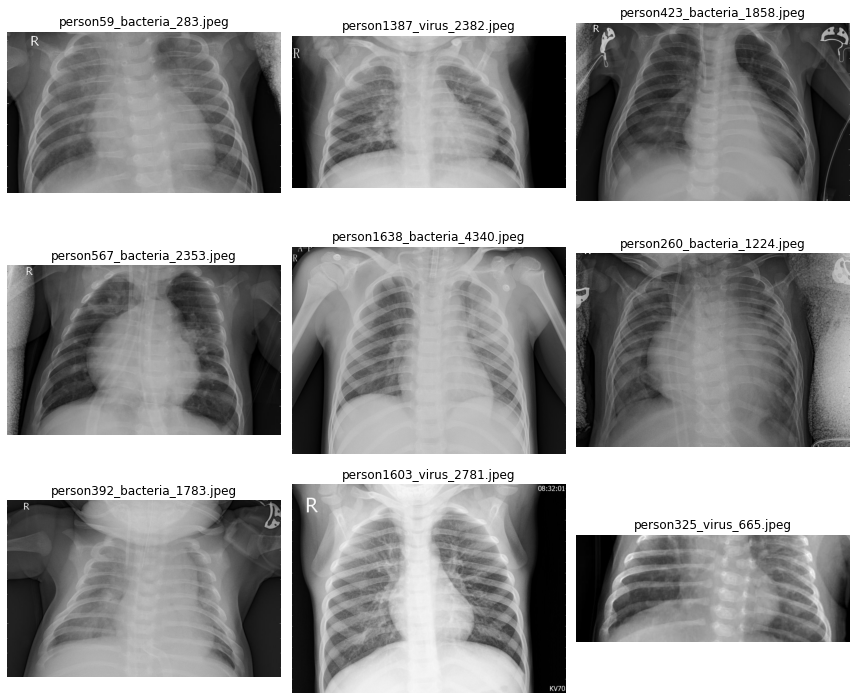

In [ ]:
all_fNames = os.listdir(DIRimg)

# image sample
sample_ids = random.sample(range(len(all_fNames)), 9)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,10))
for i, axis in enumerate(axes.flatten()):
    img = loadImage(os.path.join(DIRimg,
                    all_fNames[sample_ids[i]]), resize=False)
    imgplot = axis.imshow(img)
    axis.set_title(all_fNames[sample_ids[i]])
    axis.set_axis_off()
plt.tight_layout()

## Samples Images after Resizing

## Convert Images to Train Data

In [ ]:
# train data
x_train = np.zeros((len(all_fNames),img_size,img_size,3))
for i in tqdm(range(len(all_fNames))):
    path = os.path.join(DIRimg, all_fNames[i])
    x_train[i] = loadImage(path)

x_train = x_train / 255.
print(x_train.shape)

100%|██████████| 3875/3875 [00:34<00:00, 111.68it/s]


(3875, 128, 128, 3)


## WGAN-gp Model

### Generator

In [ ]:
def build_generator():
    input = Input(shape=z_shape)
    
    #8x8x1024
    x = Dense(4*img_size*img_size, activation="relu")(input)                            
    x = Reshape((8, 8, -1))(x)
    
    #8x8x1024 -> 16x16x512
    x = UpSampling2D((2, 2))(x)                                                         
    x = Conv2D(64*16, kernel_size=3, strides=1, padding="same", use_bias=False)(x)      
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Conv2D(64*16, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5, )(x, training=1)
    x = Activation("relu")(x)
    x = Conv2D(64*16, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Activation("relu")(x)
    
    #16x16x512 -> 32x32x256
    x = UpSampling2D((2, 2))(x)                                                         
    x = Conv2D(64*8, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Conv2D(64*8, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5, )(x, training=1)
    x = Activation("relu")(x)
    x = Conv2D(64*8, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Activation("relu")(x)
    
    #32x32x256 -> 64x64x128
    x = UpSampling2D((2, 2))(x)                                                         
    x = Conv2D(64*4, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x,training=1)
    x = Conv2D(64*4, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5, )(x, training=1)
    x = Activation("relu")(x)
    x = Conv2D(64*4, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Activation("relu")(x)
    
    #64x64x128 -> 128x128x64
    x = UpSampling2D((2, 2))(x)                                                         
    x = Conv2D(64*2, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x,training=1)
    x = Conv2D(64*2, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5, )(x, training=1)
    x = Activation("relu")(x)
    x = Conv2D(64*2, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Activation("relu")(x)
    
    #128x128x64 -> 128x128x3
    x = Conv2D(3, kernel_size=3, strides=1, padding="same", activation="tanh", use_bias=False,)(x) 

    model = Model(input, x)
    print("●generator")
    model.summary()
    return model

### Discriminator

In [ ]:
def build_discriminator():
    input = Input(shape=img_shape)
    
    # 128*128*3 -> 64x64x64 
    x = Conv2D(128, kernel_size=4, strides=2, padding="same", use_bias=False)(input)
    x = LeakyReLU(0.2)(x)
    # 64x64x64-> 32x32x128 
    x = Conv2D(256, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    # 32x32x128 -> 16x16x256  
    x = Conv2D(512, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
    x = Conv2D(512, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    # 16x16x256 -> 16x16x512
    x = Conv2D(512, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    # 16x16x512 -> 8x8x1024
    x = Conv2D(1024, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(1, kernel_size=1, strides=1, padding="same", use_bias=False)(x)
    x = Flatten()(x)
    x = Dense(units=1, activation=None)(x)   # activation = None
    
    model = Model(input, x)
    print("●discriminator")
    model.summary()
    return model

### WGan-gp Function

In [ ]:
def build_WGANgp(generator, discriminator):
    #### model
    # generator image(fake image)
    z = Input(shape=z_shape)
    f_img = generator(z)
    f_out = discriminator(f_img)
    # real image
    r_img = Input(shape=img_shape)
    r_out = discriminator(r_img)
    # average image
    epsilon = K.placeholder(shape=(None,1,1,1))
    a_img = Input(shape=(img_shape),
                  tensor = epsilon * r_img + (1-epsilon) * f_img)
    a_out = discriminator(a_img)

    #### loss
    # original critic(discriminator) loss
    r_loss = K.mean(r_out)
    f_loss = K.mean(f_out)
    # gradient penalty  <this is point of WGAN-gp>
    grad_mixed = K.gradients(a_out, [a_img])[0]
    norm_grad_mixed = K.sqrt(K.sum(K.square(grad_mixed), axis=[1,2,3]))
    grad_penalty = K.mean(K.square(norm_grad_mixed -1))
    penalty = penaltyLambda * grad_penalty
    # d loss
    d_loss = f_loss - r_loss + penalty
    
    #### discriminator update function
    d_updates = Adam(lr=1e-4, beta_1=0.5, beta_2=0.9). \
                get_updates(discriminator.trainable_weights,[],d_loss)
    d_train = K.function([r_img, z, epsilon],
                         [r_loss, f_loss, penalty, d_loss],
                         d_updates)
    
    #### generator update function
    g_loss = -1. * f_loss
    g_updates = Adam(lr=1e-4, beta_1=0.5, beta_2=0.9). \
                get_updates(generator.trainable_weights,[],g_loss)
    g_train = K.function([z], [g_loss], g_updates)

    return g_train, d_train

## Build Training Model

In [ ]:
# generator Model
generator = build_generator()
# discriminator Model
discriminator = build_discriminator()
# WGAN-gp Training Model
G_train, D_train = build_WGANgp(generator, discriminator)








●generator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 65536)             6619136   
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 1024)        0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 1024)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 1024)      9437184   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 1024)      4096      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 1024)      943

## Prepare Training

In [ ]:
# fixed z for confirmation of generated image
z_fix = np.random.normal(0, 1, (64, z_dim)) 

# list for store learning progress data
g_loss_list = []
r_loss_list = []
f_loss_list = []
f_r_loss_list = []
penalty_list = []
d_loss_list = []

# (0～1) → (-1～+1)
X_train = (x_train.astype(np.float32) - 0.5) / 0.5

### Function for ploting Images

In [ ]:
def sumple_images(imgs, rows=3, cols=3, figsize=(12,10)):
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    for indx, axis in enumerate(axes.flatten()):
        img = image.array_to_img(imgs[indx])    # ndarray → PIL
        imgplot = axis.imshow(img)
        axis.set_axis_off()
    plt.tight_layout()

## Perform Training

iteration:0 / d_loss:-1.508 / g_loss:17.402
Time Taken : 20.873107


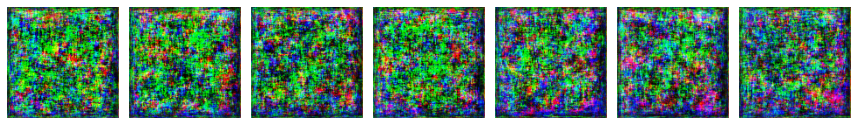

Done Iteration 1
iteration:1 / d_loss:-1.508 / g_loss:17.402
Time Taken : 21.438076
Done Iteration 2
iteration:2 / d_loss:-51.471 / g_loss:81.240
Time Taken : 5.829443
Done Iteration 3
iteration:3 / d_loss:-75.998 / g_loss:98.818
Time Taken : 5.817873
Done Iteration 4
iteration:4 / d_loss:-91.130 / g_loss:96.266
Time Taken : 5.805712
Done Iteration 5
iteration:5 / d_loss:-100.724 / g_loss:139.185
Time Taken : 5.806223
Done Iteration 6
iteration:6 / d_loss:-91.431 / g_loss:137.904
Time Taken : 5.817364
Done Iteration 7
iteration:7 / d_loss:-51.938 / g_loss:53.884
Time Taken : 5.813701
Done Iteration 8
iteration:8 / d_loss:-49.388 / g_loss:95.475
Time Taken : 5.810351
Done Iteration 9
iteration:9 / d_loss:-42.486 / g_loss:113.874
Time Taken : 5.809892
Done Iteration 10
iteration:10 / d_loss:-31.570 / g_loss:74.333
Time Taken : 5.812719
Done Iteration 11
iteration:11 / d_loss:-33.024 / g_loss:63.894
Time Taken : 5.808864
Done Iteration 12
iteration:12 / d_loss:-33.500 / g_loss:47.325
Time

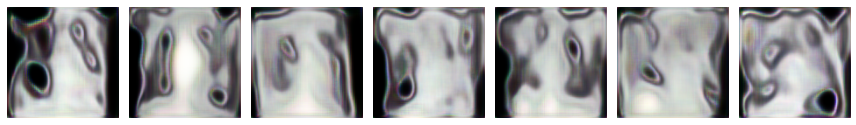

Done Iteration 101
iteration:101 / d_loss:-16.885 / g_loss:-27.241
Time Taken : 6.399031
Done Iteration 102
iteration:102 / d_loss:-21.865 / g_loss:95.601
Time Taken : 5.829008
Done Iteration 103
iteration:103 / d_loss:-16.151 / g_loss:-31.859
Time Taken : 5.814551
Done Iteration 104
iteration:104 / d_loss:-18.928 / g_loss:-41.483
Time Taken : 5.818777
Done Iteration 105
iteration:105 / d_loss:-15.789 / g_loss:54.291
Time Taken : 5.817279
Done Iteration 106
iteration:106 / d_loss:-12.506 / g_loss:31.018
Time Taken : 5.820738
Done Iteration 107
iteration:107 / d_loss:-19.700 / g_loss:-45.074
Time Taken : 5.815447
Done Iteration 108
iteration:108 / d_loss:-14.086 / g_loss:33.775
Time Taken : 5.819696
Done Iteration 109
iteration:109 / d_loss:-15.567 / g_loss:20.079
Time Taken : 5.814871
Done Iteration 110
iteration:110 / d_loss:-18.180 / g_loss:-18.222
Time Taken : 5.826688
Done Iteration 111
iteration:111 / d_loss:-12.985 / g_loss:-5.222
Time Taken : 5.838333
Done Iteration 112
iteratio

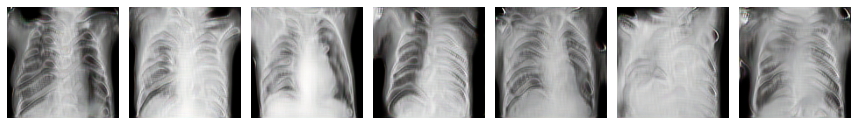

Done Iteration 501
iteration:501 / d_loss:-8.968 / g_loss:-0.548
Time Taken : 6.377992
Done Iteration 502
iteration:502 / d_loss:-11.002 / g_loss:-13.929
Time Taken : 5.825497
Done Iteration 503
iteration:503 / d_loss:-9.913 / g_loss:5.618
Time Taken : 5.832096
Done Iteration 504
iteration:504 / d_loss:-9.422 / g_loss:13.034
Time Taken : 5.818517
Done Iteration 505
iteration:505 / d_loss:-10.460 / g_loss:7.956
Time Taken : 5.825604
Done Iteration 506
iteration:506 / d_loss:-12.775 / g_loss:-23.027
Time Taken : 5.811875
Done Iteration 507
iteration:507 / d_loss:-8.238 / g_loss:6.549
Time Taken : 5.827239
Done Iteration 508
iteration:508 / d_loss:-9.568 / g_loss:25.037
Time Taken : 5.831998
Done Iteration 509
iteration:509 / d_loss:-10.649 / g_loss:-17.209
Time Taken : 5.824359
Done Iteration 510
iteration:510 / d_loss:-8.366 / g_loss:-6.433
Time Taken : 5.821236
Done Iteration 511
iteration:511 / d_loss:-10.601 / g_loss:20.330
Time Taken : 5.855383
Done Iteration 512
iteration:512 / d_l

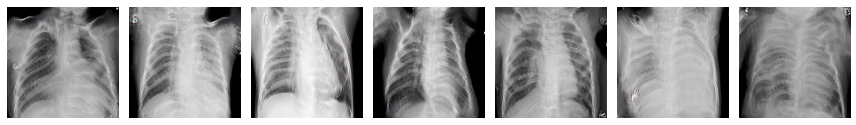

Done Iteration 1001
iteration:1001 / d_loss:-7.293 / g_loss:-3.479
Time Taken : 6.372236
Done Iteration 1002
iteration:1002 / d_loss:-6.585 / g_loss:-15.636
Time Taken : 5.825036
Done Iteration 1003
iteration:1003 / d_loss:-9.419 / g_loss:-9.838
Time Taken : 5.814262
Done Iteration 1004
iteration:1004 / d_loss:-6.807 / g_loss:16.334
Time Taken : 5.810576
Done Iteration 1005
iteration:1005 / d_loss:-7.630 / g_loss:9.109
Time Taken : 5.819625
Done Iteration 1006
iteration:1006 / d_loss:-7.431 / g_loss:-16.738
Time Taken : 5.818507
Done Iteration 1007
iteration:1007 / d_loss:-7.428 / g_loss:0.139
Time Taken : 5.818637
Done Iteration 1008
iteration:1008 / d_loss:-6.526 / g_loss:3.354
Time Taken : 5.819002
Done Iteration 1009
iteration:1009 / d_loss:-6.122 / g_loss:14.739
Time Taken : 5.813125
Done Iteration 1010
iteration:1010 / d_loss:-7.580 / g_loss:15.251
Time Taken : 5.810005
Done Iteration 1011
iteration:1011 / d_loss:-4.585 / g_loss:-18.342
Time Taken : 5.820061
Done Iteration 1012
i

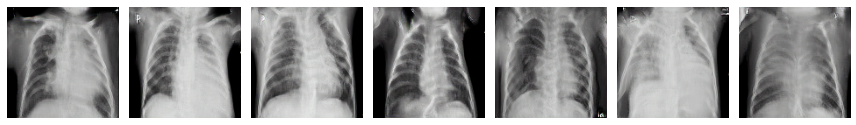

Done Iteration 1501
iteration:1501 / d_loss:-5.968 / g_loss:-9.775
Time Taken : 6.370099
Done Iteration 1502
iteration:1502 / d_loss:-7.953 / g_loss:4.709
Time Taken : 5.812728
Done Iteration 1503
iteration:1503 / d_loss:-6.882 / g_loss:13.269
Time Taken : 5.826109
Done Iteration 1504
iteration:1504 / d_loss:-6.766 / g_loss:8.819
Time Taken : 5.817396
Done Iteration 1505
iteration:1505 / d_loss:-7.804 / g_loss:-12.180
Time Taken : 5.820561
Done Iteration 1506
iteration:1506 / d_loss:-6.004 / g_loss:-9.835
Time Taken : 5.810225
Done Iteration 1507
iteration:1507 / d_loss:-7.173 / g_loss:1.758
Time Taken : 5.818590
Done Iteration 1508
iteration:1508 / d_loss:-9.101 / g_loss:2.376
Time Taken : 5.815423
Done Iteration 1509
iteration:1509 / d_loss:-7.383 / g_loss:18.727
Time Taken : 5.807770
Done Iteration 1510
iteration:1510 / d_loss:-7.547 / g_loss:9.209
Time Taken : 5.810689
Done Iteration 1511
iteration:1511 / d_loss:-6.934 / g_loss:-27.018
Time Taken : 5.826399
Done Iteration 1512
iter

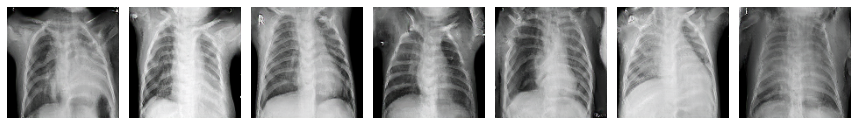

Done Iteration 2001
iteration:2001 / d_loss:-6.093 / g_loss:0.830
Time Taken : 6.356367
Done Iteration 2002
iteration:2002 / d_loss:-6.590 / g_loss:2.292
Time Taken : 5.805631
last iteration: 2001


In [ ]:
import time

iteration = 0
while iteration<=2001:
    
    start_time = time.time()
    #### Discriminator
    for j in range(trainRatio):
        # Generator in
        z = np.random.normal(0, 1, (batch_size, z_dim))
        # Generator out Images
        f_imgs = generator.predict(z)
        # Real Images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        r_imgs = X_train[idx]
        # train the discriminator
        epsilon = np.random.uniform(size = (batch_size, 1,1,1))
        r_loss, f_loss, penalty, d_loss = D_train([r_imgs, z, epsilon])

    #### Generator
    # Generator in
    z = np.random.normal(0, 1, (batch_size, z_dim))
    # train the generator
    g_loss = G_train([z])

    #### Record of learning progress
    # loss
    r_loss_list.append(r_loss)
    f_loss_list.append(f_loss)
    f_r_loss_list.append(f_loss - r_loss)
    penalty_list.append(penalty)
    d_loss_list.append(d_loss)
    # generated image sumple
    if (iteration in [100, 1000]) or (iteration % 500 == 0):
        print(f'iteration:{iteration} / d_loss:{d_loss:.3f} / g_loss:{sum(g_loss)/len(g_loss):.3f}')
        print('Time Taken : %f' % (time.time()-start_time))
        g_imgs = generator.predict(z_fix)
        imgs = g_imgs * 127.5 + 127.5
        sumple_images(imgs, rows=1, cols=7)
        plt.show()

    iteration += 1
    print('Done Iteration %d'%iteration)
    print(f'iteration:{iteration} / d_loss:{d_loss:.3f} / g_loss:{sum(g_loss)/len(g_loss):.3f}')
    print('Time Taken : %f' % (time.time()-start_time))
print("last iteration:",iteration - 1)

## Plot the Graphs

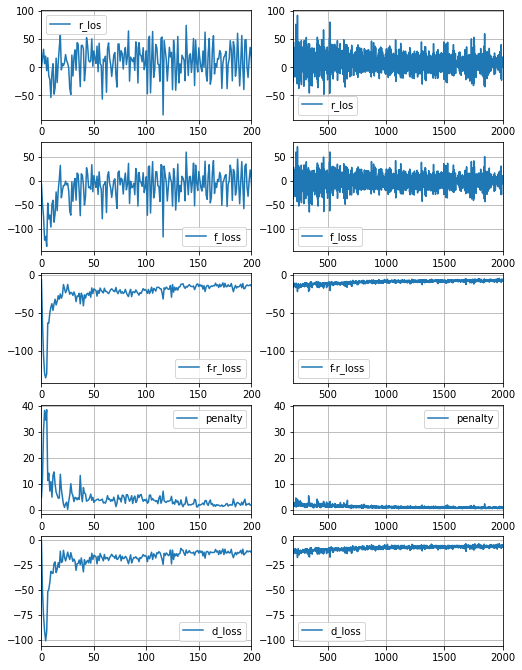

In [ ]:
# plot loss
fig, ax = plt.subplots(5, 2, figsize=(8.27,11.69))
for j in range(2):
    ax[0,j].plot(r_loss_list, label="r_los")
    ax[1,j].plot(f_loss_list, label="f_loss")
    ax[2,j].plot(f_r_loss_list, label="f-r_loss")
    ax[3,j].plot(penalty_list, label="penalty")
    ax[4,j].plot(d_loss_list, label="d_loss")
for i in range(5):
    ax[i,0].set_xlim([0,200])
    ax[i,1].set_xlim([200,iteration])
    for j in range(2):
        ax[i,j].grid()
        ax[i,j].legend()
plt.savefig('normal_128')
plt.show()

## Create Output Directory

In [ ]:
if os.path.exists(DIRout):
    shutil.rmtree(DIRout)
if not os.path.exists(DIRout):
    os.mkdir(DIRout)

## Generate Sample Images Using Training Model

In [ ]:
# generate images for submit
n = 5000
batch = 64
for i in tqdm(range(0, n, batch)):
    z = np.random.normal(0,1,size=(batch, z_dim))
    g_imgs = generator.predict(z)
    imgs = g_imgs * 127.5 + 127.5
    for j in range(batch):
        img = image.array_to_img(imgs[j])      # ndarray → PIL 
        img.save(os.path.join(DIRout, 'image_' + str(i+j+1).zfill(5) + '.png'))
        if i+j+1 == n:
            break
print(len(os.listdir(DIRout)))

100%|██████████| 79/79 [01:27<00:00,  1.11s/it]

5000


## Plot the sample Images

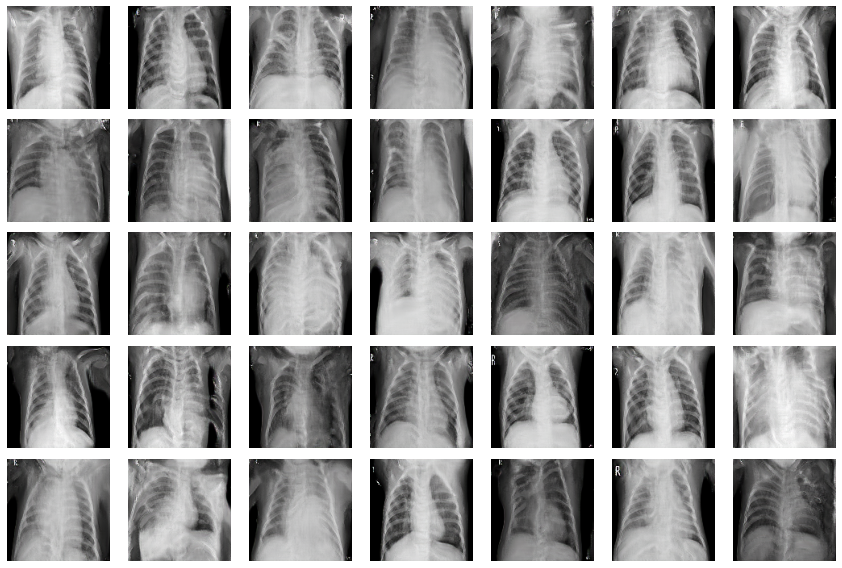

In [ ]:
# generated xrays sumple
sumple_images(g_imgs, rows=5, cols=7, figsize=(12,8))

## Submit the Directory

In [ ]:
if os.path.exists('pneumonia_128.zip'):
    os.remove('pneumonia_128.zip')
shutil.make_archive('pneumonia_128', 'zip', DIRout)
print("<END>")

<END>


'My Drive'/


In [ ]:
mv /content/pneumonia_128.zip /content/drive/My Drive/Assdf2/Assdf

mv: target 'Drive/Assdf2/Assdf' is not a directory
